### Validation of layer profiles of midrange connectivity
➤ Actual synapse densities vs. layer profiles used in the recipe

In [1]:
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from bluepy import Circuit
from wm_utility.wm_recipe_utility import lookup_population_in_recipe
from wm_utility import validate_wm_layer_profiles

# Path to the wm-style recipe that has been used to create the connectivity [from SSCXDIS-323]
fn_recipe = "./data/rat_wm_recipe_tr_ll_ul_un_n_m_subtract_adjacents.yaml"

# Circuit config
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_WM'

# Midrange projections name
proj_name = 'intra_SSCX_midrange_wm'

# Load recipe
with open(fn_recipe, "r") as fid:
    recipe = yaml.load(fid, Loader=yaml.SafeLoader)

# Load circuit & get midrange projections
c = Circuit(circuit_config)
fn_proj = c.config['projections'][proj_name]
proj_path = os.path.join(os.path.split(fn_proj)[0], 'feathers')

# Prepare saving
figs_path = './figs'
if not os.path.exists(figs_path):
    os.mkdir(figs_path)

save_path = './working_dir'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [2]:
# Get all projections
projections = []
src_regions = []
tgt_regions = []
profiles = []
densities = []
proj_files = []
for proj in recipe['projections']:
    src = proj['source']
    src_name = lookup_population_in_recipe(src, recipe)
    for tgt in proj['targets']:
        tgt_name = lookup_population_in_recipe(tgt['population'], recipe)
        projections.append(tgt['projection_name'])
        src_regions.append(src_name)
        tgt_regions.append(tgt_name)
        profiles.append(tgt['target_layer_profiles'][0]['name'])
        densities.append(tgt['density'])
        proj_files.append(os.path.join(proj_path, tgt['projection_name'] + '.feather'))

regions = np.unique(np.hstack(tgt_regions)) # All target regions
print(f'{len(projections)} projections to {len(regions)} target regions found in recipe:')
for pidx in range(len(projections)):
    print(f'{projections[pidx]}: {"/".join(src_regions[pidx])}-{"/".join(tgt_regions[pidx])} ({profiles[pidx]})', end='')
    
    # Check if corrsponding projection file exists
    if not os.path.exists(proj_files[pidx]):
        print(f' ERROR: FILE NOT FOUND')
    else:
        print(' ... OK')


111 projections to 8 target regions found in recipe:
SSp-tr_23_to_SSp-ll_ipsi: S1Tr-S1HL (profile_6) ... OK
SSp-tr_23_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_6) ... OK
SSp-tr_23_to_SSp-un_ipsi: S1Tr-S1DZ (profile_3) ... OK
SSp-tr_4_to_SSp-ll_ipsi: S1Tr-S1HL (profile_3) ... OK
SSp-tr_4_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_3) ... OK
SSp-tr_4_to_SSp-un_ipsi: S1Tr-S1DZ (profile_3) ... OK
SSp-tr_5it_to_SSp-ll_ipsi: S1Tr-S1HL (profile_4) ... OK
SSp-tr_5it_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_4) ... OK
SSp-tr_5it_to_SSp-un_ipsi: S1Tr-S1DZ (profile_1) ... OK
SSp-tr_5pt_to_SSp-ll_ipsi: S1Tr-S1HL (profile_4) ... OK
SSp-tr_5pt_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_4) ... OK
SSp-tr_5pt_to_SSp-un_ipsi: S1Tr-S1DZ (profile_4) ... OK
SSp-tr_6_to_SSp-ll_ipsi: S1Tr-S1HL (profile_6) ... OK
SSp-tr_6_to_SSp-ul_ipsi: S1Tr-S1FL/S1Sh (profile_6) ... OK
SSp-tr_6_to_SSp-un_ipsi: S1Tr-S1DZ (profile_6) ... OK
SSp-ll_23_to_SSp-tr_ipsi: S1HL-S1Tr (profile_3) ... OK
SSp-ll_23_to_SSp-ul_ipsi: S1HL-S1FL/S1Sh (

In [82]:
# Load atlas
atlas_regions, layers, atlas_ids, vox_rel_depth = validate_wm_layer_profiles.load_brain_atlas(c, regions)

LOADED 6 layers and 8 regions from brain atlas


In [83]:
# Load layer profiles from recipe
profiles_list = list(np.unique(profiles))
rel_density_layer_profiles = {}
for profile in profiles_list:
    rel_density_layer_profiles.update({profile: validate_wm_layer_profiles.rel_density_profile_from_recipe(recipe, profile)})
print(f'LOADED {len(profiles_list)} relative layer profiles from recipe: {profiles_list}')

LOADED 4 relative layer profiles from recipe: ['profile_1', 'profile_3', 'profile_4', 'profile_6']


In [84]:
# Estimate overall layer boundaries
rel_layer_depth_range, rel_layer_thickness = validate_wm_layer_profiles.estimate_layer_boundaries(vox_rel_depth, atlas_regions, [atlas_ids])
rel_layer_depth_range = rel_layer_depth_range[0]
rel_layer_thickness = rel_layer_thickness[0]

In [ ]:
# # Estimate depth profiles for all projections [MEAN OVER ALL TARGET REGIONS]
# num_rel_depth_bins = 50
# rel_depth_density_hists = []
# for pidx in range(len(projections)):
#     print(f'{pidx + 1} of {len(projections)}:', end=' ')
#     proj_file = proj_files[pidx]
#     fn = os.path.join(save_path, os.path.splitext(os.path.split(proj_file)[1])[0]) + '__depth_hist.npz'
#     if os.path.exists(fn):
#         print(f'FILE {fn} EXISTS ... Loading from file!')
#         data = np.load(fn)
#         rel_depth_density_hist = data['rel_depth_density_hist']
#         rel_depth_bins = data['rel_depth_bins']
#     else:
#         reg_idx = np.array([np.where(r == regions)[0] for r in tgt_regions[pidx]]).flatten()
#         rel_depth_density_hist, rel_depth_bins = validate_wm_layer_profiles.estimate_depth_profiles(proj_file, atlas_regions, [atlas_ids[:, reg_idx]], vox_rel_depth, num_rel_depth_bins)
#         np.savez(fn, rel_depth_density_hist=rel_depth_density_hist, rel_depth_bins=rel_depth_bins) # SAVE TO FILE
#     rel_depth_density_hists.append(rel_depth_density_hist)
# rel_depth_density_hists = np.hstack(rel_depth_density_hists)

In [ ]:
# # Plot single selected density profile
# sel_idx = 4
# proj_name = projections[sel_idx]
# profile_name = profiles[sel_idx]
# tgt_name = '-'.join(tgt_regions[sel_idx])
# density_layer_profile = densities[sel_idx] * rel_density_layer_profiles[profile_name]
# validate_wm_layer_profiles.plot_rel_density_profiles(rel_depth_density_hists[:, [sel_idx]], rel_depth_bins, [tgt_name], [rel_layer_depth_range], density_layer_profile, fig_title=f'{proj_name} vs. {profile_name}', unit='Density\n[#Syn/$\mu$m$^3$]', save_path=figs_path)

In [ ]:
# Estimate depth profiles for all projections [SEPARATELY FOR ALL REGIONS]
num_rel_depth_bins = 50
rel_depth_density_hists = []
for pidx in range(len(projections)):
    print(f'{pidx + 1} of {len(projections)}:', end=' ')
    proj_file = proj_files[pidx]
    fn = os.path.join(save_path, os.path.splitext(os.path.split(proj_file)[1])[0]) + '__depth_hist_all_reg.npz'
    if os.path.exists(fn):
        print(f'FILE {fn} EXISTS ... Loading from file!')
        data = np.load(fn)
        rel_depth_density_hist = data['rel_depth_density_hist']
        rel_depth_bins = data['rel_depth_bins']
    else:
        rel_depth_density_hist, rel_depth_bins = validate_wm_layer_profiles.estimate_depth_profiles(proj_file, atlas_regions, [atlas_ids[:, [r]] for r in range(len(regions))], vox_rel_depth, num_rel_depth_bins)
        np.savez(fn, rel_depth_density_hist=rel_depth_density_hist, rel_depth_bins=rel_depth_bins) # SAVE TO FILE
    rel_depth_density_hists.append(rel_depth_density_hist)

In [ ]:
# Plot single selected density profiles [ALL REGIONS]
for sel_idx in range(len(projections)):
    proj_name = projections[sel_idx]
    profile_name = profiles[sel_idx]
    tgt_idx = np.array([np.where(r == regions)[0] for r in tgt_regions[sel_idx]]).flatten()
    density_layer_profile = rel_density_layer_profiles[profile_name] * densities[sel_idx] / np.sum(rel_density_layer_profiles[profile_name] * rel_layer_thickness)
    validate_wm_layer_profiles.plot_rel_density_profiles(rel_depth_density_hists[sel_idx], rel_depth_bins, regions, len(regions) * [rel_layer_depth_range], [density_layer_profile if r in tgt_idx else np.zeros_like(density_layer_profile) for r in range(len(regions))], fig_title=f'{proj_name} vs. {profile_name} (subregions)', unit='Density\n[#Syn/$\mu$m$^3$]', num_rows=1, save_path=figs_path)

In [ ]:
# Plot single selected density profiles [MEAN OVER TARGET REGIONS]
tgt_mean_histograms = []
tgt_names = []
tgt_layer_profiles = []
for sel_idx in range(len(projections)):
    proj_name = projections[sel_idx]
    profile_name = profiles[sel_idx]
    tgt_name = '-'.join(tgt_regions[sel_idx])
    tgt_idx = np.array([np.where(r == regions)[0] for r in tgt_regions[sel_idx]]).flatten()
    density_layer_profile = rel_density_layer_profiles[profile_name] * densities[sel_idx] / np.sum(rel_density_layer_profiles[profile_name] * rel_layer_thickness)
    tgt_mean_histograms.append(np.mean(rel_depth_density_hists[sel_idx][:, tgt_idx], 1, keepdims=True))
    tgt_names.append(f'{proj_name}\n({profile_name})')
    tgt_layer_profiles.append(density_layer_profile)
validate_wm_layer_profiles.plot_rel_density_profiles(np.hstack(tgt_mean_histograms), rel_depth_bins, tgt_names, len(tgt_layer_profiles) * [rel_layer_depth_range], tgt_layer_profiles, fig_title='All projections overview', unit='Density\n[#Syn/$\mu$m$^3$]', num_rows=8, save_path=figs_path)

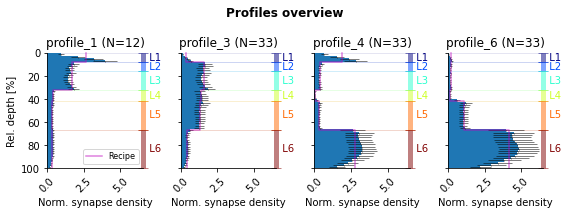

In [121]:
# Plot mean densities per profile (normalized densities based on rel. target profile densities)
tgt_norm_mean_histograms = []
for sel_idx in range(len(projections)):
    tgt_idx = np.array([np.where(r == regions)[0] for r in tgt_regions[sel_idx]]).flatten()
    profile_name = profiles[sel_idx]
    scale_factor = densities[sel_idx] / np.sum(rel_density_layer_profiles[profile_name] * rel_layer_thickness)
    tgt_norm_mean_histograms.append(np.mean(rel_depth_density_hists[sel_idx][:, tgt_idx], 1, keepdims=True) / scale_factor) # Normalize!

profile_densities_mean = []
profile_densities_std = []
profile_names = []
for profile in profiles_list:
    sel_idx = np.where(np.array(profiles) == profile)[0]
    hist_mean = np.mean(np.hstack(tgt_norm_mean_histograms)[:, sel_idx], 1, keepdims=True)
    hist_std = np.std(np.hstack(tgt_norm_mean_histograms)[:, sel_idx], 1, keepdims=True)
    profile_densities_mean.append(hist_mean)
    profile_densities_std.append(hist_std)
    profile_names.append(f'{profile} (N={len(sel_idx)})')

validate_wm_layer_profiles.plot_rel_density_profiles(np.hstack(profile_densities_mean), rel_depth_bins, profile_names, len(profiles_list) * [rel_layer_depth_range], [rel_density_layer_profiles[p] for p in profiles_list], err_bars=np.hstack(profile_densities_std), fig_title='Profiles overview', unit='Norm. synapse density', num_rows=1, save_path=figs_path)

In [26]:
### OLD CODE ###

In [ ]:
# # Load synapse property tables (incl. positions) of midrange projections
# sel_idx = 4
# proj_name = projections[sel_idx]
# print(f'PROCESSING {proj_name}...')
# syn_table = pd.read_feather(proj_files[sel_idx])

In [162]:
# # Rel. depth profiles (voxel-based densities & depth estimates)

# ## Voxel-based synapse densities
# syn_pos = syn_table[['x', 'y', 'z']]
# syn_atlas_idx = atlas_regions.positions_to_indices(syn_pos.values)
# idx, cnt = np.unique(syn_atlas_idx, axis=0, return_counts=True)
# vox_syn_count = np.zeros_like(atlas_regions.raw, dtype=int)
# vox_syn_count[idx[:, 0], idx[:, 1], idx[:, 2]] += cnt # Count synapses per voxel => DUPLICATES TO BE TAKEN INTO ACCOUNT!!
# vox_syn_density = vox_syn_count / atlas_regions.voxel_volume # (#Syn/um3)

# ## Depth histogram per region
# num_rel_depth_bins = 50
# rel_depth_bins = np.linspace(np.nanmin(vox_rel_depth), np.nanmax(vox_rel_depth), num_rel_depth_bins + 1)
# rel_depth_bin_centers = np.array([np.mean(rel_depth_bins[i : i + 2]) for i in range(num_rel_depth_bins)])

# rel_depth_values = vox_rel_depth[~np.isnan(vox_rel_depth)]
# density_values = vox_syn_density[~np.isnan(vox_rel_depth)]
# # regid_values = atlas_regions.raw[~np.isnan(vox_rel_depth)]

# rel_depth_density_hist = np.zeros((num_rel_depth_bins, len(regions)))
# for ridx, reg in enumerate(regions):
#     for didx in range(num_rel_depth_bins):
#         dmin = rel_depth_bins[didx]
#         dmax = rel_depth_bins[didx + 1]
#         if didx + 1 == num_rel_depth_bins:
#             dmax += 1 # So that border values also included in last bin
#         dsel = np.logical_and(rel_depth_values >= dmin, rel_depth_values < dmax)
#         rsel = np.in1d(regid_values, atlas_ids[:, ridx])
#         if np.sum(np.logical_and(dsel, rsel)) > 0:
#             rel_depth_density_hist[didx, ridx] = np.mean(density_values[np.logical_and(dsel, rsel)]) # Mean density in a given depth range
#         else:
#             rel_depth_density_hist[didx, ridx] = 0.0

In [164]:
# # Extract density profile from recipe
# profile_idx = np.where([profile['name'] == profiles[sel_idx] for profile in recipe['layer_profiles']])[0][0]
# profile_recipe = recipe['layer_profiles'][profile_idx]['relative_densities']

# density_layer_profile = np.zeros(len(layers))
# for p_idx, p_dict in enumerate(profile_recipe):
#     for lay in p_dict['layers']:
#         density_layer_profile[int(lay[1:]) - 1] = densities[sel_idx] * p_dict['value']

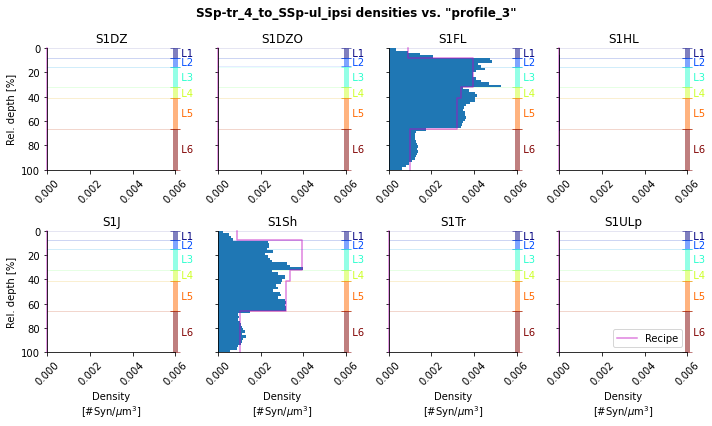

In [175]:
# # Plot rel. synapse density profiles (voxel-based)
# lcolors = plt.cm.jet(np.linspace(0, 1, len(layers)))
# plt.figure(figsize=(10, 6))
# plt.gcf().patch.set_facecolor('w')
# for ridx, reg in enumerate(regions):
#     plt.subplot(2, np.ceil(len(regions) / 2).astype(int), ridx + 1)
#     plt.barh(100.0 * rel_depth_bin_centers, rel_depth_density_hist[:, ridx], np.diff(100.0 * rel_depth_bin_centers[:2]))
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.xlim([0, 0.006])
#     plt.ylim([100.0 * rel_depth_bins[0], 100.0 * rel_depth_bins[-1]])
#     plt.gca().invert_yaxis()
#     plt.xticks(rotation=45)
#     plt.title(reg)
#     if ridx >= np.ceil(len(regions) / 2).astype(int):
#         plt.xlabel('Density\n[#Syn/$\mu$m$^3$]')
#     ## Plot layer boundaries
#     for lidx, lay in enumerate(layers):
#         plt.plot(np.ones(2) * max(plt.xlim()), 100.0 * rel_layer_depth_range[lidx, ridx, :], '-_', color=lcolors[lidx, :], linewidth=5, alpha=0.5, solid_capstyle='butt', markersize=10, clip_on=False)
#         plt.text(max(plt.xlim()), 100.0 * np.mean(rel_layer_depth_range[lidx, ridx, :]), '  L{}'.format(lay), color=lcolors[lidx, :], ha='left', va='center')
#         plt.plot(plt.xlim(), np.ones(2) * 100.0 * rel_layer_depth_range[lidx, ridx, 0], '-', color=lcolors[lidx, :], linewidth=1, alpha=0.1, zorder=0)
#         plt.plot(plt.xlim(), np.ones(2) * 100.0 * rel_layer_depth_range[lidx, ridx, 1], '-', color=lcolors[lidx, :], linewidth=1, alpha=0.1, zorder=0)
#     if np.mod(ridx, np.ceil(len(regions) / 2).astype(int)) == 0:
#         plt.ylabel('Rel. depth [%]')
#     else:
#         plt.gca().set_yticklabels([])

#     # Plot intended densities from recipe
#     if reg in tgt_regions[sel_idx]:
#         pscale = 1.0
#     else:
#         pscale = 0.0
#     plt.step(pscale * np.repeat(density_layer_profile, 2), 100.0 * rel_layer_depth_range[:, ridx, :].flatten(), 'm', where='post', linewidth=1.5, alpha=0.5, clip_on=False, label='Recipe')
# plt.legend(loc='lower right')
# plt.suptitle(f'{projections[sel_idx]} densities vs. "{profiles[sel_idx]}"', fontweight='bold')
# plt.tight_layout()
# plt.savefig(os.path.join(figs_path, f'{projections[sel_idx]}_profiles.png'), dpi=300)
# plt.show()